The graphics in this RISE slideshow may not fit to certain screens or resolutions.  

How do you achieve the following using clustering techniques?

A company wants to segment its customers.

You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

Conduct the analysis in Jupyter. Provide a complete research report using the framework introduced in the previous module. The report should include compelling visualizations and actionable insights, telling the story to your intended audience. Walk through the analysis using clean, reproducible code. Include plenty of notes and comments to guide others through your thinking.

Rather than create a deck in a presentation tool like PowerPoint or Google Slides, we will use Jupyter’s built-in slide deck capabilities. This cuts down on the time-consuming and error-prone process of copying-and-pasting into an external program. The presentation is also fully reproducible.

On the day of your presentation, an evaluator from the Thinkful educator team will introduce you, and then you'll give your presentation. Afterward, the evaluator will ask you follow up questions and will grade your performance on your presentation. Members of the audience will also be encouraged to ask follow up questions.

Be prepared to talk about:

Your end-user and the value your project provides to them.
Quantifiable results based on the research you’ve conducted.
The visuals you chose and what they represent for your research.
Next steps you'd take to expand on your work.
A specified research question your model addresses.
How you chose your model specification and what alternatives you compared it to.
The practical uses of your model for an audience of interest.
Any weak points or shortcomings of your model.

### Overview

In this kernel, we will compare clustering algorithms on their ability to segment the population into distinct and meaningful groups.

The dataset contains credit card spending habits, but is not labeled and thus contains no ground truth.  Thus, we cannot use external evaluation metrics (such as Adjusted RAND Index) to asses the clusters.  In this analysis we will use internal evaluation metrics (silhouette score, Davies-Bouldin index, and Calinski-Harabasz index) to assess the models.  

We will begin with K-Means clustering, compare it to a Gaussian Mixture model, and then see if a Hierarchical Agglomerative or DBSCAN algorithm is effective.  Throughout, we will examine the advantages and shortcomings of each model.  

By the end of the analysis, we will identify the most effective segmentation model and unique characteristic of each segment.  These characteristics can then be used to devise a marketing strategy or predict future behavior.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn import datasets, metrics
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

Importing the data

In [2]:
raw_df = pd.read_csv('Dataset zips/ccdata/CC GENERAL.csv')

In [3]:
df = raw_df.copy()

### Data Exploration

The datatypes look accurate for each field.

Two fields contain fewer values than the number of records and thus have null values.  There is one missing value for CREDIT_LIMIT and a few hundred for MINIMUM_PAYMENTS.

The CUST_ID field is an object, and is unnessasary for this analysis, so it will be dropped.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

To address these null values, we will impute the mean for that field.  We will also drop the meaningless field for customer id.

In [5]:
df = df.drop(['CUST_ID'], axis = 1)
df['CREDIT_LIMIT'].fillna(value = df['CREDIT_LIMIT'].mean(), inplace = True)
df['MINIMUM_PAYMENTS'].fillna(value = df['MINIMUM_PAYMENTS'].mean(), inplace = True)

We can examine the descriptive statistics to identify the range and variance of each field.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


Since there are not too many features, we can use histograms to examine the distributions of each feature.  In this dataset, no field has a normal distribution.  

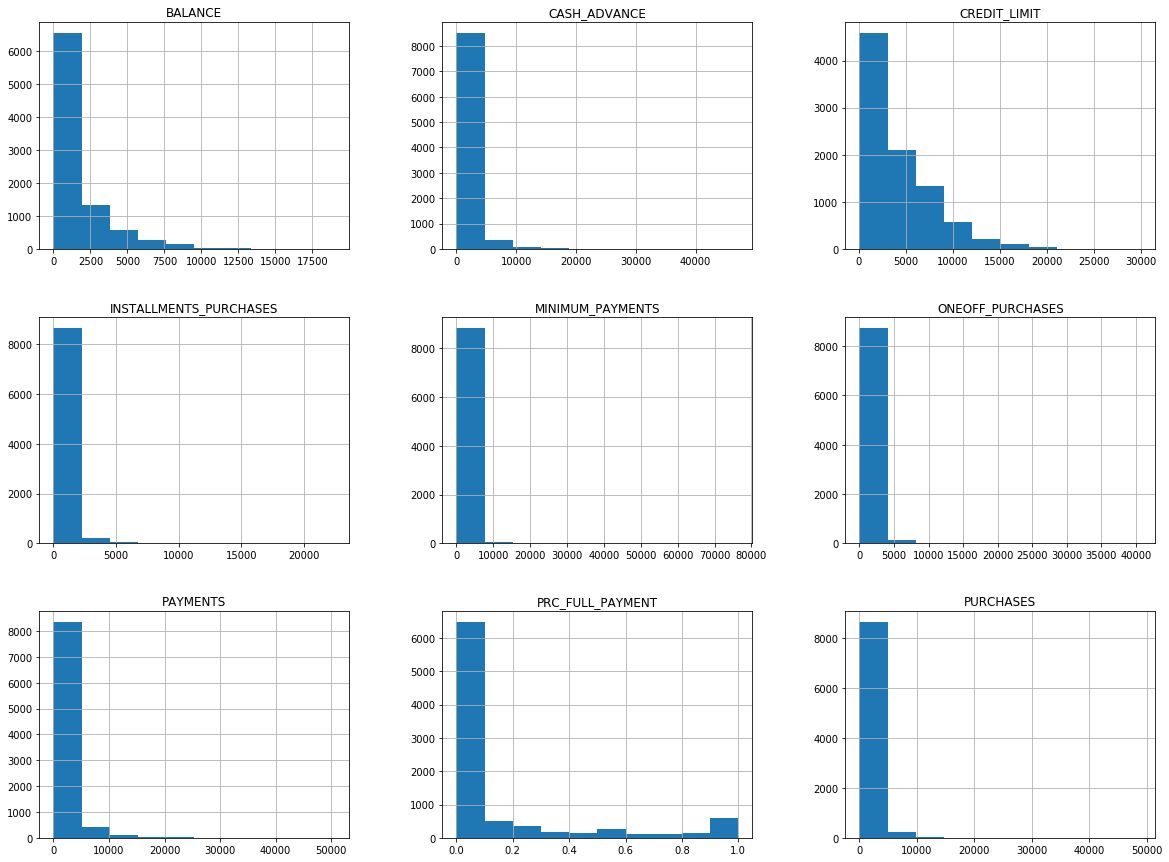

In [7]:
df[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']].hist(figsize = (20, 15))
plt.show()

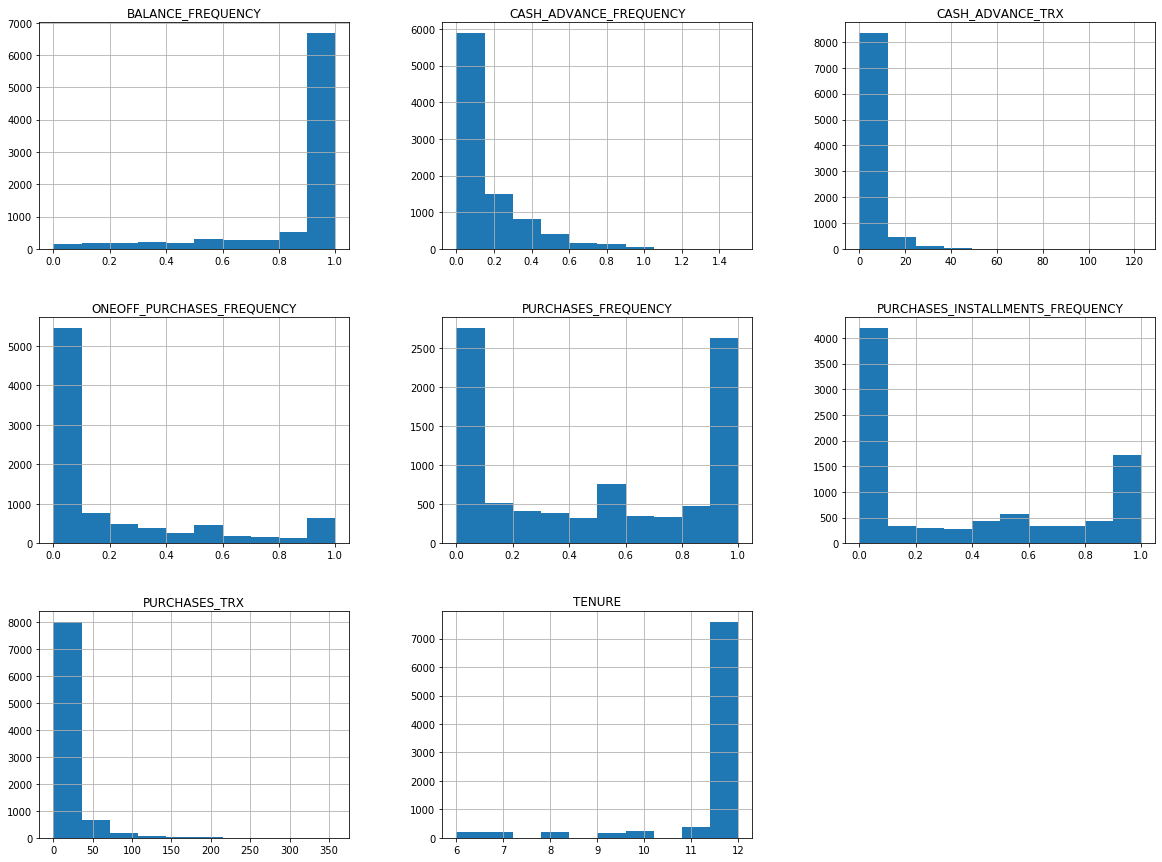

In [8]:
df[['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE']].hist(figsize = (20, 15))
plt.show()

#### Transforming the data

Normally, for data with gaussian distributions, it would be prudent to standardize the data in each field so they have comparable variance.  However, none of the fields have normal distributions.  Thus we will not standardize the data in this case.  

We will still normalize the data so fields with larger values do not dominate the models.  All data will be scaled to between 0 and 1.

We will then reduce the data to two dimensions.  This removes some information, but will be valuable for later visualizations and preserves as much information as possible.  It also does not drop any particular field.  

In [9]:
# Standarizing the features
#scaler = StandardScaler()

#standardized_df = scaler.fit_transform(df)
#df_std = pd.DataFrame(standardized_df)

normalized_df = normalize(df)
df_norm = pd.DataFrame(normalized_df) 

In [10]:
# Dimension reduction to 2 features
pca = PCA(n_components=2).fit_transform(df_norm)

df_pca = pd.DataFrame(pca, columns = ['component_1', 'component_2'])

### Evaluating Clustering Algorithms

As we move forward, we will aggregate the best performance of each algorithm in a dataframe, df_scores.

Some of the models depend on a random state.  For consistency, we will set all random states to 123456.

Throughout this analysis, we will use the silhouette score, Davies Bouldin index, and Calinski Harabraz index to evaluate each model and choose the ideal number of clusters.  

In [11]:
df_scores = pd.DataFrame(columns = ['algorithm', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])

In [12]:
state = 123456

#### Metrics

Silhouette score: This metric measures the distance between each data point, the centroid of its assigned cluster and the closest centroid of another cluster. This compares its cohesion to its cluster with its separation from other clusters.  It works well for determining 
Values range from -1 to 1.  Higher values close to 1 are desired.

Calinski-Harabasz index: This metric measure the ratio of between cluster variance to within cluster variance.  It tends to prefer cluster solutions with clusters consisting of roughly the same number of objects and are roughly spherical with compact centers.  Thus it is most effective for K-Means algorithms, but we will use it throughout this analysis.
Values range from 0 to infinity. Higher values are desired

Davies-Bouldin index: This metric measure ratio of the scatter within the cluster the separation between clusters.  Thus, it evaluates intra-cluster similarity and inter-cluster differences.  It works out to be the average similarity between each cluster and the next most similar cluster, averaged over all clusters.
Values range from 0 to 1.  Lower values close to 0 are desired.  

#### K-Means

To start, we will examine the K-Means clustering algorithm.  This will create clusters with comparable size.  Thus, each group should have a similar number of datapoints.  

We can use the elbow method to choose a number of clusters to explore.  We are looking for areas where the error begins to flatten as number of clusters increases.

This flattening begins at 3 clusters.  The error becomes relatively flat by 9 clusters.  Thus our analysis will focus on a number of cluster between 2 and 9.  

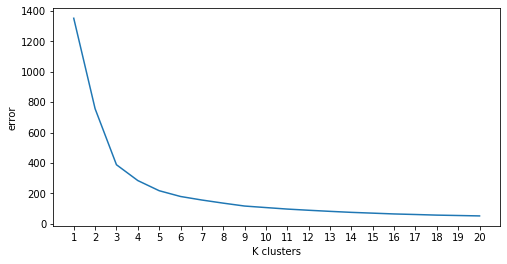

In [13]:
errors = {}
for k in range(1, 21):
    kmeans_cluster = KMeans(n_clusters = k, random_state = state).fit(df_pca)
    errors[k] = kmeans_cluster.inertia_  # Sum of distances of samples to their closest cluster center 
plt.figure(figsize = (8, 4))
plt.plot(list(errors.keys()), list(errors.values()))
plt.xticks(range(1, 21))
plt.xlabel("K clusters")
plt.ylabel("error")
plt.show()

#### Examining metrics

Generally less clusters is better, even if metrics slightly improve.  We will be looking for areas where metrics dramatically improve from the last number of clusters.  

In [14]:
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
clusters = range(2, 10)

for k in clusters:
    silhouette_scores.append(silhouette_score(df_pca, KMeans(n_clusters = k, random_state = state).fit_predict(df_pca)))
    calinski_harabasz_scores.append(calinski_harabasz_score(df_pca, KMeans(n_clusters = k, random_state = state).fit_predict(df_pca)))
    davies_bouldin_scores.append(davies_bouldin_score(df_pca, KMeans(n_clusters = k, random_state = state).fit_predict(df_pca)))

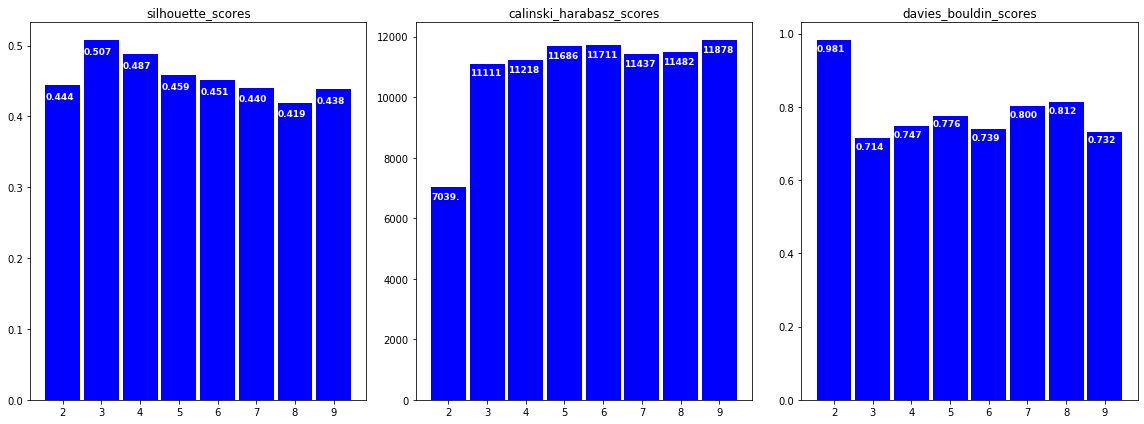

In [15]:
plt.figure(figsize = (16, 6))
plt.subplot(131)
plt.bar(clusters, silhouette_scores, color = 'b', width = 0.9)
plt.title('silhouette_scores')
for index,data in enumerate(silhouette_scores):
    plt.text(x = index + 1.55, y = data - .02, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.subplot(132)
plt.bar(clusters, calinski_harabasz_scores, color = 'b', width = 0.9)
plt.title('calinski_harabasz_scores')
for index,data in enumerate(calinski_harabasz_scores):
    plt.text(x = index + 1.55, y = data - 400, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.subplot(133)
plt.bar(clusters, davies_bouldin_scores, color = 'b', width = 0.9)
plt.title('davies_bouldin_scores')
for index,data in enumerate(davies_bouldin_scores):
    plt.text(x = index + 1.55, y = data - .03, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.tight_layout()

For the K-Means algorithm, 3 clusters has the highest silhouette score at 0.507.  There is also a significant jump from 2 to 3 clusters for the Calinski Harabasz index, but a minor change from 3 to 4 and beyond.  For the Davies Bouldin index, 3 clusters also has the lowest value.  

Therefore, for the K-Means algorithm, 3 clusters seems to be the optimal number for distint grouping.  We can examine these clusters with 2 dimensional visualization because we reduced to 2 components with PCA.

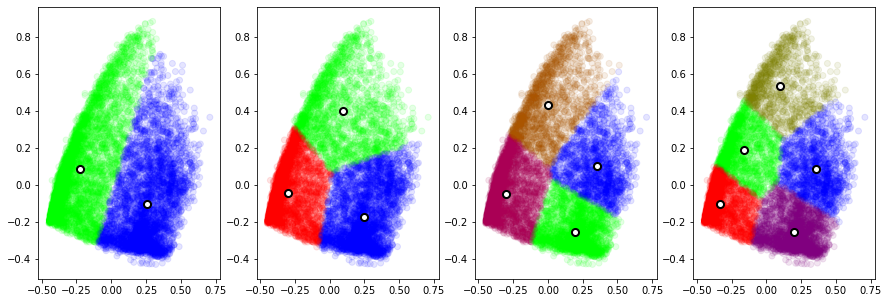

In [16]:
plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    df_kmean_centers = pd.DataFrame(KMeans(n_clusters = k, random_state = state).fit(df_pca).cluster_centers_)
    plt.subplot(subplots[count])
    plt.scatter(df_pca['component_1'], df_pca['component_2'], c = KMeans(n_clusters = k, random_state = state).fit_predict(df_pca), cmap = 'brg', alpha = 0.1)
    plt.scatter(df_kmean_centers[0], df_kmean_centers[1], c = 'White', marker = 'o', s = 50, edgecolors = 'Black', linewidths = 2)
    count += 1
plt.show()

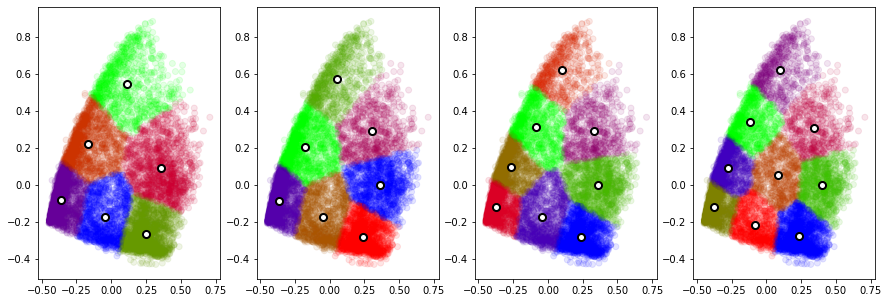

In [17]:
plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(6, 10):
    df_kmean_centers = pd.DataFrame(KMeans(n_clusters = k, random_state = state).fit(df_pca).cluster_centers_)
    plt.subplot(subplots[count])
    plt.scatter(df_pca['component_1'], df_pca['component_2'], c = KMeans(n_clusters = k, random_state = state).fit_predict(df_pca), cmap = 'brg', alpha = 0.1)
    plt.scatter(df_kmean_centers[0], df_kmean_centers[1], c = 'White', marker = 'o', s = 50, edgecolors = 'Black', linewidths = 2)
    count += 1
plt.show()

Overall, the data becomes sparser in the center as evidenced by the lower opacity of points in the scatter plot.  In general, adding an additional cluster appears to divide a region that used to occupy two clusters into 3 clusters.  This is likely why there is no significant increase in metrics after 3 clusters. 

We can concluse that 3 is the most effective number of clusters, we will add the metrics for a 3_means clustering solution to our dataframe of scores.  

In [18]:
df_clusters_3_means = pd.DataFrame(KMeans(n_clusters = 3, random_state = state).fit(df_pca).predict(df_pca))
df['3_MEANS'] = df_clusters_3_means
df_scores = df_scores.append({'algorithm' : '3-means' , 'silhouette_score' : silhouette_score(df_pca, KMeans(n_clusters = 3, random_state = state).fit_predict(df_pca)), 'calinski_harabasz_score' : calinski_harabasz_score(df_pca, KMeans(n_clusters = 3, random_state = state).fit_predict(df_pca)), 'davies_bouldin_score' : davies_bouldin_score(df_pca, KMeans(n_clusters = 3, random_state = state).fit_predict(df_pca))}, ignore_index = True)

#### Gaussian Mixture Model

Unlike a K-Means algorithm, the Gaussian Mixture Model can identify clusters of varied size.  This may be useful if there is a specific minority group that can be targeted.  

It is important to note that the Calinki Harabasz index is not as effective on clusters of different sizes. 

In [19]:
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
clusters = range(2, 10)

for k in clusters:
    silhouette_scores.append(silhouette_score(df_pca, GaussianMixture(n_components = k, random_state = state).fit_predict(df_pca)))
    calinski_harabasz_scores.append(calinski_harabasz_score(df_pca, GaussianMixture(n_components = k, random_state = state).fit_predict(df_pca)))
    davies_bouldin_scores.append(davies_bouldin_score(df_pca, GaussianMixture(n_components = k, random_state = state).fit_predict(df_pca)))

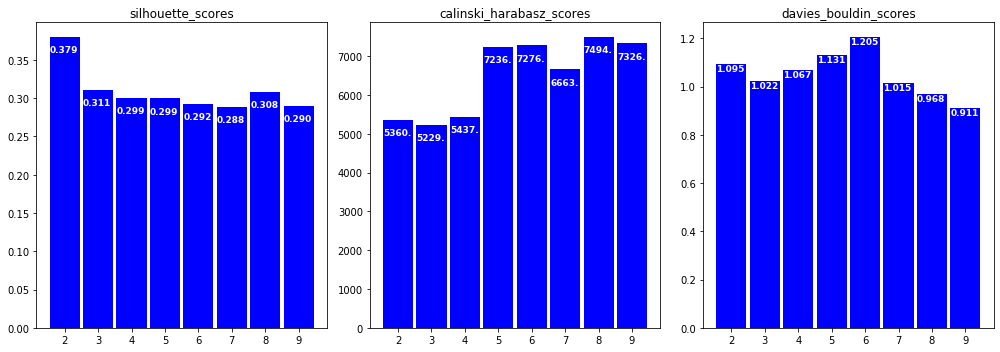

In [20]:
plt.figure(figsize = (14, 5))
plt.subplot(131)
plt.bar(clusters, silhouette_scores, color = 'b', width = 0.9)
plt.title('silhouette_scores')
for index,data in enumerate(silhouette_scores):
    plt.text(x = index + 1.55, y = data - .02, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.subplot(132)
plt.bar(clusters, calinski_harabasz_scores, color = 'b', width = 0.9)
plt.title('calinski_harabasz_scores')
for index,data in enumerate(calinski_harabasz_scores):
    plt.text(x = index + 1.55, y = data - 400, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.subplot(133)
plt.bar(clusters, davies_bouldin_scores, color = 'b', width = 0.9)
plt.title('davies_bouldin_scores')
for index,data in enumerate(davies_bouldin_scores):
    plt.text(x = index + 1.55, y = data - .03, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.tight_layout()

For the Gaussian Mixture Model, it is more difficult to identify the optimal number of clusters.  The highest silhouette score occurs at 2 clusters, but this solution is not especially interesting or useful.  We want to devide the population into more than two groups.  

The next highest silhouette scores are 3 clusters at .311, and 8 at 0.308.  However, the scores are very close for all number of clusters.  

The Davie Bouldin index is minimized for 9 clusters, but that is also one of the lowest silhouette scores.  8 is second lowest, and has a noticible jump in the silhouette score graph aswell.  Additionally, while Calinski Harabasz is not the most effective model for different sized clusters, 8 cluster has the highest score for that metric.  Thus, it seems that for the Gaussian Mixture Model, 8 clusters performs the best across all 3 metrics.  

We can examine the scatter plots of each cluster to see if we can identify why.

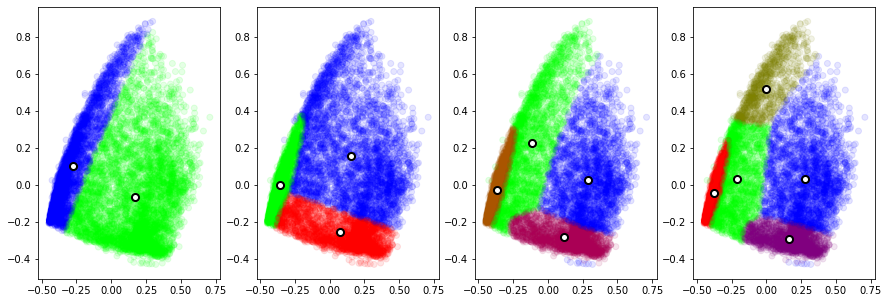

In [21]:
plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    df_gmm_centers = pd.DataFrame(GaussianMixture(n_components = k, random_state = state).fit(df_pca).means_)
    plt.subplot(subplots[count])
    plt.scatter(df_pca['component_1'], df_pca['component_2'], c = GaussianMixture(n_components = k, random_state = state).fit_predict(df_pca), cmap = 'brg', alpha = 0.1)
    plt.scatter(df_gmm_centers[0], df_gmm_centers[1], c = 'White', marker = 'o', s = 50, edgecolors = 'Black', linewidths = 2)
    count += 1
plt.show()

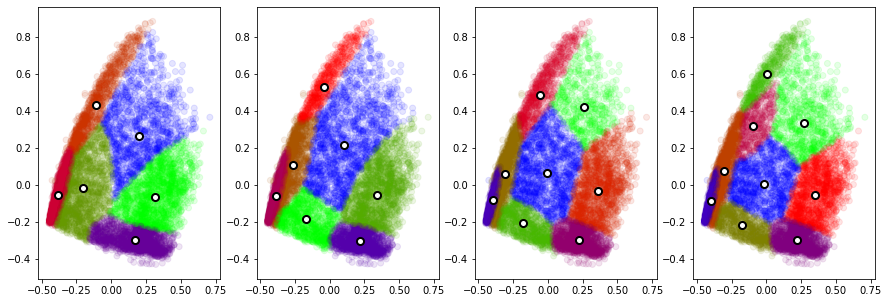

In [22]:
plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(6, 10):
    df_gmm_centers = pd.DataFrame(GaussianMixture(n_components = k, random_state = state).fit(df_pca).means_)
    plt.subplot(subplots[count])
    plt.scatter(df_pca['component_1'], df_pca['component_2'], c = GaussianMixture(n_components = k, random_state = state).fit_predict(df_pca), cmap = 'brg', alpha = 0.1)
    plt.scatter(df_gmm_centers[0], df_gmm_centers[1], c = 'White', marker = 'o', s = 50, edgecolors = 'Black', linewidths = 2)
    count += 1
plt.show()

The main things to notice when examining the 8 cluster scatter is the center cluster in blue.  In the 7 cluster solution there is no center cluster, so increasing from 7 to 8 introduces a cluster for all the records that fall in that center area and would otherwise be close to any of the surrounding clusters, reducing the overall metrics.  Thus we will choose 8 clusters for the Gaussian Mixture Model as the best perfoming hyperparameter.  

In [23]:
df_clusters_8_gmm = pd.DataFrame(GaussianMixture(n_components = 8, random_state = state).fit(df_pca).predict(df_pca))
df['8_GMM'] = df_clusters_8_gmm
df_scores = df_scores.append({'algorithm' : '8_gmm' , 'silhouette_score' : silhouette_score(df_pca, GaussianMixture(n_components = 8, random_state = state).fit_predict(df_pca)), 'calinski_harabasz_score' : calinski_harabasz_score(df_pca, GaussianMixture(n_components = 8, random_state = state).fit_predict(df_pca)), 'davies_bouldin_score' : davies_bouldin_score(df_pca, GaussianMixture(n_components = 8, random_state = state).fit_predict(df_pca))}, ignore_index = True)

#### Hierarchical Agglomerative Clustering

In the Hierarchical Agglomerative clustering algorithm, each datapoint will start its own cluster, then similar pairs will be merged until we reach the optimal number of clusters.  This method is slow, O(n^3), but our dataset is not too large for this to be prohibitive. 

The advantage of Heirarchical Agglomerative clustering is that very similar datapoints will always be in the same cluster, instead of straddling the boundary.  However, it can create clusters of vastly different size, and may not assign clusters based on the overall similarity of their members.  

Since clusters are not uniform in size, the Calinski-Harabasz index may not be the most effective metric.  Additionally, since the Davie-Bouldin index measure variance within the cluster, it may also not be effective as disimilar clusters are merged higher up in the tree.  

We will explore all of the various linkage and affinity types.

In [24]:
df_agg_scores = pd.DataFrame(columns = ['linkage', 'affinity', 'clusters', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])

In [25]:
def score_agg_cluster(data, n_clusters, linkage_type, affinity_type):
    global df_agg_scores
    agg_cluster = AgglomerativeClustering(linkage=linkage_type, 
                                          affinity=affinity_type,
                                          n_clusters=n_clusters)
    clusters = agg_cluster.fit_predict(data)
    df_agg_scores = df_agg_scores.append({'linkage' : linkage_type, 'affinity' : affinity_type, 'clusters' : n_clusters, 'silhouette_score' : metrics.silhouette_score(df_pca, clusters, metric=affinity_type), 'calinski_harabasz_score' : metrics.calinski_harabasz_score(df_pca, clusters), 'davies_bouldin_score' : metrics.davies_bouldin_score(df_pca, clusters)}, ignore_index = True)

In [26]:
# Long runtime
data = df_pca
for linkages in ['complete', 'average']:
    linkage_type = linkages
    for affinities in ['cosine', 'euclidean', 'manhattan']:
        affinity_type = affinities
        for clusters in range(2, 8):
            score_agg_cluster(data, clusters, linkage_type, affinity_type)
            
linkage_type='ward'
affinity_type='euclidean'
for clusters in range(2, 8):
    score_agg_cluster(data, clusters, linkage_type, affinity_type)


In [27]:
df_agg_scores.sort_values(by = ['silhouette_score'], ascending = [False]).head(10)

,linkage,affinity,clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
1,complete,cosine,3,0.729717,10598.741504,0.762234
21,average,cosine,5,0.718231,9298.184089,0.769731
20,average,cosine,4,0.717822,10296.569733,0.795004
22,average,cosine,6,0.705660,8682.548739,0.899315
23,average,cosine,7,0.674949,8799.650297,0.907934
18,average,cosine,2,0.643140,6800.659165,1.004234
5,complete,cosine,7,0.642146,8534.652212,1.023508
19,average,cosine,3,0.637430,7982.897686,0.753045
2,complete,cosine,4,0.630695,8290.698115,0.878552
3,complete,cosine,5,0.618137,8807.535587,0.927826


In [28]:
df_agg_scores.sort_values(by = ['calinski_harabasz_score'], ascending = [False]).head(10)

,linkage,affinity,clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
1,complete,cosine,3,0.729717,10598.741504,0.762234
20,average,cosine,4,0.717822,10296.569733,0.795004
25,average,euclidean,3,0.480442,10082.284760,0.771335
40,ward,euclidean,6,0.416031,9794.759333,0.828823
41,ward,euclidean,7,0.405300,9702.567116,0.876872
15,complete,manhattan,5,0.430546,9626.452892,0.791756
33,average,manhattan,5,0.441994,9416.564365,0.725671
26,average,euclidean,4,0.453275,9333.464972,0.796691
10,complete,euclidean,6,0.413322,9323.388167,0.846451
21,average,cosine,5,0.718231,9298.184089,0.769731


In [29]:
df_agg_scores.sort_values(by = ['davies_bouldin_score'], ascending = [True]).head(10)

,linkage,affinity,clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
30,average,manhattan,2,0.356796,1109.576230,0.648352
32,average,manhattan,4,0.415797,6512.590459,0.716973
33,average,manhattan,5,0.441994,9416.564365,0.725671
14,complete,manhattan,4,0.411995,7321.598755,0.727437
8,complete,euclidean,4,0.393761,6259.081667,0.739009
27,average,euclidean,5,0.438607,8255.000680,0.739011
19,average,cosine,3,0.637430,7982.897686,0.753045
9,complete,euclidean,5,0.418620,9145.644573,0.753338
39,ward,euclidean,5,0.419397,9145.426175,0.756644
31,average,manhattan,3,0.406484,5423.506904,0.757331


Creating 3 clusters with the complete linkage and cosine affinity results in the highest silhouette score of 0.729.  This is significantly higher than our earlier clustering algorithms.  The Calinski-Harabasz index also identifies these hyperparameters as the most effective.  The lowest Davies-Bouldin index is paired with a low silhouette score and is thus not a good metric for this application.  The complete cosine 3 cluster solution also has a realtively low Davies-Bouldin index, and thus seems to be the clear winner.  

We can inspect the dendrogram for these hyperparemeters.

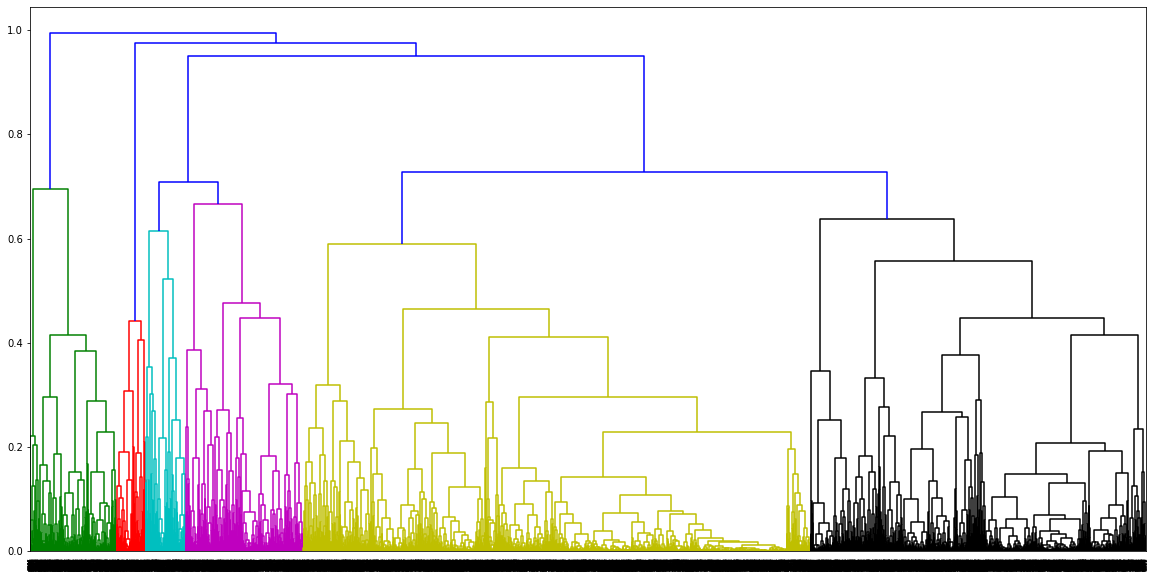

In [30]:
# Long runtime
plt.figure(figsize=(20,10))
dendrogram(linkage(df_norm, method = 'complete', metric = 'cosine'))
plt.show()

Focusing on the part of the dendrogram with 3 clusters (a horizontal line cuts 3 vertical lines) it appears that there is one very large cluster on the right, and 2 small cluster on the left.  The center red cluster is especially small.  This is concerning if we want to target groups of roughly equal size.  However, it is identifying some distinct minority groups in the population. 

In [31]:
linkage_type='complete'
affinity_type='cosine'


agg_cluster = AgglomerativeClustering(linkage=linkage_type, 
                                      affinity=affinity_type,
                                      n_clusters=3)
clusters = agg_cluster.fit_predict(df_pca)
df['3_COM_COS_AGG'] = clusters
df_scores = df_scores.append({'algorithm' : '3_Com_Cos_Agg' , 'silhouette_score' : metrics.silhouette_score(df_pca, clusters, metric=affinity_type),'calinski_harabasz_score' : metrics.calinski_harabasz_score(df_pca, clusters), 'davies_bouldin_score' : metrics.davies_bouldin_score(df_pca, clusters)}, ignore_index = True)

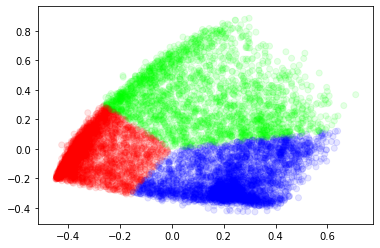

In [32]:
plt.scatter(df_pca['component_1'], df_pca['component_2'], c = clusters, cmap = 'brg', alpha = 0.1)
plt.show()

#### DBSCAN

I do not expect the Density Based Spatial Clustering of Applications with Noise to be an effective model in this case.  Its strength is finding oddly shaped clusters such as rings, and excluding outlying datapoints as noise.  We do not want to exclude datapoints in this case if we are targeting all customers. We will examine it anyways to rule it out.

In [33]:
# Long runtime
silhouette_scores = []
best_silhouette = pd.DataFrame(data = {'epsilon': [0], 'min_samples': [0], 'clusters': [0], 'silhouette_score': [0]})
for eps in np.arange(0.02, .5, 0.02):
    for samples in range(2, 30, 2):
        dbscan_series = pd.Series(DBSCAN(eps = eps, min_samples = samples).fit_predict(df_pca))
        if dbscan_series.unique().shape[0] > 1:
            silhouette = silhouette_score(df_pca, DBSCAN(eps = eps, min_samples = samples).fit_predict(df_pca))
            silhouette_scores.append(silhouette)
            if silhouette > best_silhouette['silhouette_score'][0]:
                best_silhouette.loc[0] = [eps, samples, dbscan_series.unique().shape[0], silhouette]

In [34]:
best_silhouette

,epsilon,min_samples,clusters,silhouette_score
0,0.08,10,2,0.373237


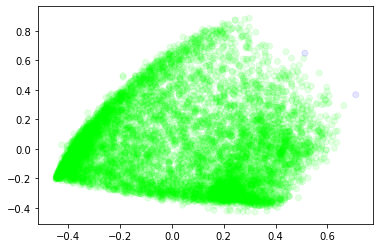

In [35]:
plt.scatter(df_pca['component_1'], df_pca['component_2'], c = DBSCAN(eps=0.08, min_samples=10).fit_predict(df_pca), cmap = 'brg', alpha = 0.1)
plt.show()

The best scoring model simply has one large cluster and a couple of noise datapoints.  The silhouette score is not especially high either.  DBSCAN is not effective in this application.

### Comparing the Models

Now that we have found the optimal hyperparameters for each model, we can compare them and decide which is most effective for this application.  We will create a table to compare their scores and discuss the implications of each.

In [36]:
df_scores

,algorithm,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,3-means,0.507403,11111.808662,0.714928
1,8_gmm,0.308263,7494.570464,0.968006
2,3_Com_Cos_Agg,0.729717,10598.741504,0.762234


Agglomerative clustering has the highest silhouette score, but a 3 cluster K-Means algorithm has the highest calinski-harabasz index and a lower davies-bouldin score.  As noted above, these two metrics are not especially effective for Agglomerative clustering and that my be the reason they do not conform to the silhouette metric.  The Gaussian Mixture model performed worst for all three metrics and thus is not the most effective model.   

How do the agglomertive and K-Means clusters compare?

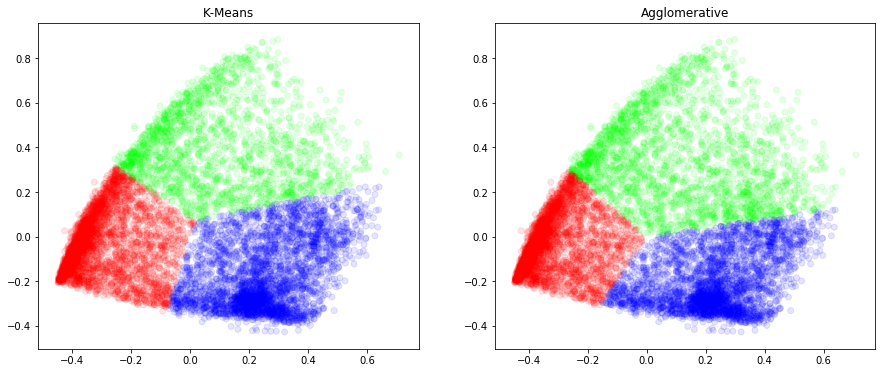

In [37]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
plt.scatter(df_pca['component_1'], df_pca['component_2'], c = KMeans(n_clusters = 3, random_state = state).fit_predict(df_pca), cmap = 'brg', alpha = 0.1)
plt.title('K-Means')
plt.subplot(122)
plt.scatter(df_pca['component_1'], df_pca['component_2'], c = clusters, cmap = 'brg', alpha = 0.1)
plt.title('Agglomerative')
plt.show()

#### Characteristics for 3 Clusters

We will compare the mean value of each field grouped by cluster for the K-Means algorithm and the Agglomerative algorithm.

It is apparent that both algorithms found very simialr clusters, thus either would be suitable for making marketing descisions.

In [38]:
k_max = 3
columns = ['feature']
for k in range(0, k_max):
    columns.append('mean_{}'.format(k))
    columns.append('std_{}'.format(k))
df_3_means_stats = pd.DataFrame(columns = columns)
for col in df.columns:
    stats = {'feature' : col}
    for k in range(0, k_max):
        stats.update({'mean_{}'.format(k) : df[col][df['{}_MEANS'.format(k_max)] == k].mean()})
        stats.update({'std_{}'.format(k) : df[col][df['{}_MEANS'.format(k_max)] == k].std()})
    df_3_means_stats = df_3_means_stats.append(stats, ignore_index = True)

In [39]:
k_max = 3
columns = ['feature']
for k in range(0, k_max):
    columns.append('mean_{}'.format(k))
    columns.append('std_{}'.format(k))
df_3_agg_stats = pd.DataFrame(columns = columns)
for col in df.columns:
    stats = {'feature' : col}
    for k in range(0, k_max):
        stats.update({'mean_{}'.format(k) : df[col][df['{}_MEANS'.format(k_max)] == k].mean()})
        stats.update({'std_{}'.format(k) : df[col][df['{}_MEANS'.format(k_max)] == k].std()})
    df_3_agg_stats = df_3_agg_stats.append(stats, ignore_index = True)

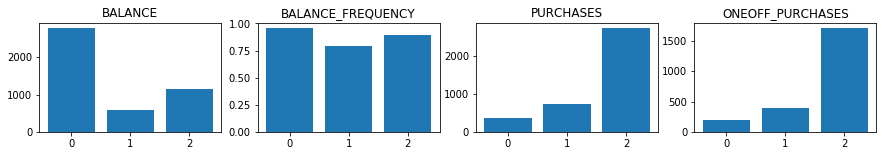

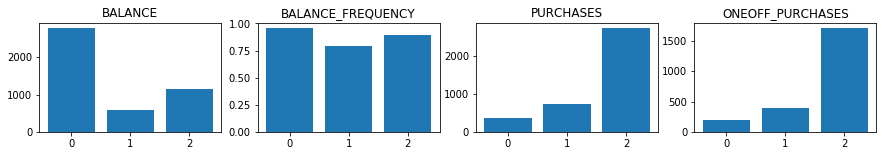

In [40]:
plt.figure(figsize = (15, 2))
subplots = [141, 142, 143, 144]
count = 0
for inx, feature in enumerate(df_3_agg_stats['feature'][0:4]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_agg_stats['mean_{}'.format(k)][df_3_agg_stats['feature'] == feature][inx])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.figure(figsize = (15, 2))
count = 0
for inx, feature in enumerate(df_3_means_stats['feature'][0:4]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_means_stats['mean_{}'.format(k)][df_3_means_stats['feature'] == feature][inx])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.show()

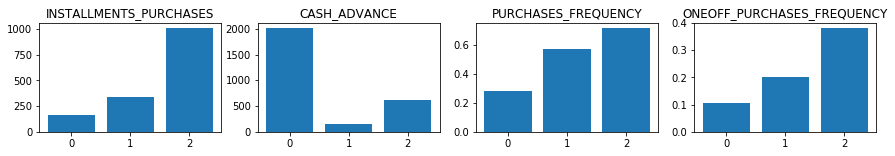

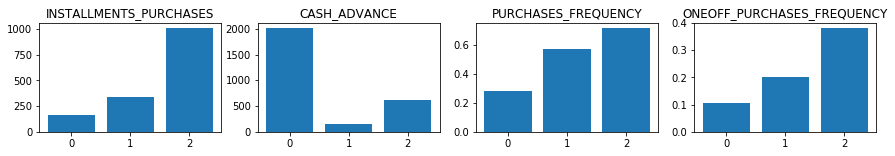

In [42]:
plt.figure(figsize = (15, 2))
subplots = [141, 142, 143, 144]
count = 0
for inx, feature in enumerate(df_3_agg_stats['feature'][4:8]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_agg_stats['mean_{}'.format(k)][df_3_agg_stats['feature'] == feature][inx+4])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.figure(figsize = (15, 2))
count = 0
for inx, feature in enumerate(df_3_means_stats['feature'][4:8]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_means_stats['mean_{}'.format(k)][df_3_means_stats['feature'] == feature][inx+4])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.show() 

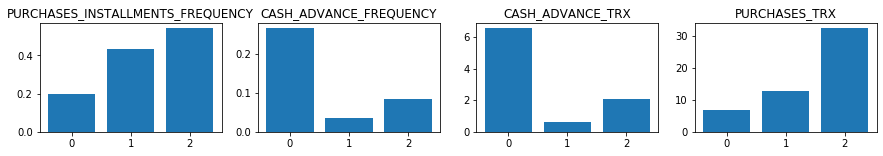

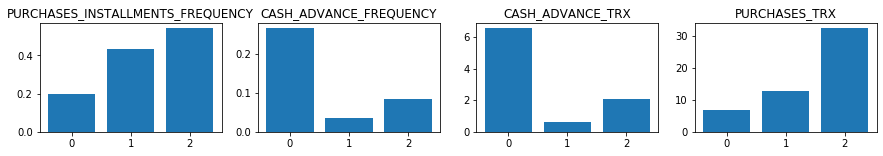

In [43]:
plt.figure(figsize = (15, 2))
subplots = [141, 142, 143, 144]
count = 0
for inx, feature in enumerate(df_3_agg_stats['feature'][8:12]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_agg_stats['mean_{}'.format(k)][df_3_agg_stats['feature'] == feature][inx+8])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.figure(figsize = (15, 2))
count = 0
for inx, feature in enumerate(df_3_means_stats['feature'][8:12]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_means_stats['mean_{}'.format(k)][df_3_means_stats['feature'] == feature][inx+8])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.show()

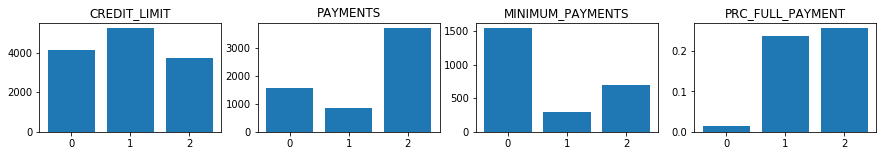

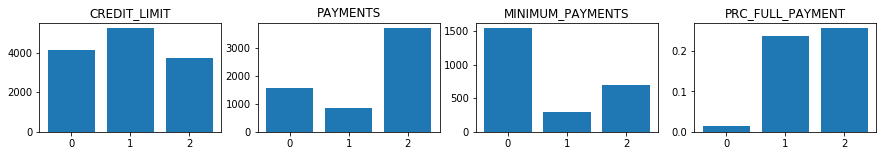

In [44]:
plt.figure(figsize = (15, 2))
subplots = [141, 142, 143, 144]
count = 0
for inx, feature in enumerate(df_3_agg_stats['feature'][12:16]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_agg_stats['mean_{}'.format(k)][df_3_agg_stats['feature'] == feature][inx+12])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.figure(figsize = (15, 2))
count = 0
for inx, feature in enumerate(df_3_means_stats['feature'][12:16]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_means_stats['mean_{}'.format(k)][df_3_means_stats['feature'] == feature][inx+12])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.show()

Cluster 0: This group generally runs a high balance, but has a low number of purchases.  They make most purchases with a cash advance, and usually pay the minimum balance, thus paying off a low percentage of the balance. 

Cluster 1: This group runs a low balance and does not use cash advance often.  They pay off most of the low balance instead of  only making minimum payments.  They purchase fairly often, but pay off the balance before purchasing more.  Since this group seems to have responsible spending habits, they have the highest creadit limits.  

Cluster 2: This group runs a medium balance, but make many purchases often.  They thus have the highest payments.  They occasionalyl use cash advance, but usually pay up straight.  They avoid minimum payments when they can, but sometimes resort to just paying the minimum, unlike cluster 1.  Notably, this cluster likes to use installment purchases.

For marketing, target plans with low minimum payments and a generous cash advance system at cluster 0.  A high interest rate will make money off this group because they continuously run a balance, but they may not choose a plan with a high rate if they are self aware of that.  

Target plans with high credit limits, low interest rates, and higher minimum payments at cluster 1.  They can be depended on to pay their balance, and will not end up paying much interest.  The hgiher minimum payment will not be important to them so it increases the floor of earnings on this group for the company.  

Target plans with installment policies at cluster 2.  Perhaps limit their credit since they can not always be depended on to pay off the balance.  This group seems to make big one off purchases so they may like rewards targeted at big ticket items (flights?).  


### Shortcomings

This entire analysis is based on reducing dimensions to 2 components using Principal Component Analysis.  This means that, while we preserved as much information as possible, some was lost.  

We did not identify outliers or transform skewed distributions.  There were too many values close to 0 to perform an effective boxcox or log transformation to attempt to get the distributions close to normal.  However, if we could achieve a normal distribution for most fields, we could then standardize the data before normalizing it.  This would make the data spherical and this metrics such as Calinski-Harabasz would be more effective at identifying distinct clusters.  

### Further Analysis

Instead of reducing dimensions to 2 components for effective visualization, we could instead increase the number of components to preserve information. The 2D plots would not show clear separation in this case, but the groups may be more distinct.  It might be prudent to explore another dimension reduction algorithm besides PCA.

We could also examine more metrics such as the Dunn index for identifying the optimal number of clusters and best model.  